In [26]:
import csv
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import operator #need this for sorting dicts later
import matplotlib.cm as cm #for colormapping later
from matplotlib.colors import LogNorm
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
%matplotlib inline

Import custom restauramt and not_restaurant csv files as dataframes

In [27]:
not_restaurant_df = pd.read_csv('not_restaurant.csv')
not_restaurant_df = not_restaurant_df.drop(['Unnamed: 0','city','distance'], 1)
not_restaurant_df = not_restaurant_df.drop_duplicates(subset=['name','postal_code','latitude','longitude','neighborhood'], keep=False)
pubs_df = pd.read_csv('pubs.csv')
pubs_df = pubs_df.drop(['city','Unnamed: 0'], 1)
pubs_df = pubs_df.drop_duplicates(subset=['name','postal_code','latitude','longitude','neighborhood'], keep=False)
pubs_df['index_no'] = pubs_df.index
pubs_df.head()

,name,postal_code,latitude,longitude,neighborhood,categories,stars,review_count,index_no
0,McCarthy's Irish Pub,M4L 2B5,43.678049,-79.314774,Upper Beach,"[u'Pubs', u'Restaurants', u'Bars', u'Irish', u...",4.0,5,0
1,Boardwalk Place,M4W 3L6,43.663010,-79.310898,NaN,"[u'American (Traditional)', u'Restaurants', u'...",3.0,13,1
2,The Yellow Griffin,M6S 1N4,43.651439,-79.475629,Bloor-West Village,"[u'Pubs', u'Restaurants', u'Burgers', u'Nightl...",3.0,98,2
3,Cabin Fever,M6P 1A6,43.655350,-79.456719,High Park,"[u'Cafes', u'Art Galleries', u'Arts & Entertai...",4.5,26,3
4,Bar Homestand,M6G 1M2,43.662600,-79.423726,Christie Pits,"[u'Comfort Food', u'Pubs', u'Bars', u'Sports B...",3.5,5,4


In [28]:
not_restaurant_df.describe()

,latitude,longitude,stars,review_count
count,3738.000000,3738.000000,3738.000000,3738.000000
mean,43.659746,-79.390947,3.702381,12.928571
std,0.863939,0.454143,0.979130,24.914754
min,-9.095137,-79.653939,1.000000,3.000000
25%,43.649911,-79.419545,3.000000,4.000000
50%,43.662539,-79.395460,4.000000,6.000000
75%,43.680457,-79.378843,4.500000,13.000000
max,43.844762,-51.833829,5.000000,530.000000


In [32]:
pubs_df.describe()

,latitude,longitude,stars,review_count,index_no
count,203.000000,203.000000,203.000000,203.000000,203.000000
mean,43.668998,-79.388099,3.391626,63.502463,186.078818
std,0.032415,0.057959,0.580695,101.331891,90.279454
min,43.599790,-79.603882,2.000000,3.000000,0.000000
25%,43.650502,-79.414682,3.000000,16.500000,112.500000
50%,43.660418,-79.390206,3.500000,33.000000,187.000000
75%,43.673362,-79.363302,4.000000,71.500000,269.500000
max,43.796148,-79.170583,4.500000,1087.000000,347.000000


In [33]:
final_businesses_df = pd.DataFrame()

def haversine(x):
    
    global not_restaurant_df
    global final_businesses_df
    
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
    
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(not_restaurant_df['latitude']), np.radians(not_restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    not_restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   # print("4. pubs gets a new distace col", pubs_df)
    
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = not_restaurant_df
   # print("5. Another new dataframe is init, it equals pubs_df", measure_1)
    measure_1 = measure_1.loc[(not_restaurant_df['distance'] > 0.0) & (not_restaurant_df['distance'] <=1.0)]
    #print("Measure_1 is now", measure_1)
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    #print("mean biz rating is calc", mean_rating)
    density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    final_businesses_df = final_businesses_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, "density": density}, ignore_index=True)
    return final_businesses_df


for line in pubs_df['index_no']:
    x = pubs_df.loc[pubs_df['index_no'] == line]
    haversine(x)


# Relationship Between Pub Rating and Non Pub Business Density

We are interested in looking at the relationship between pub ratings and the density of non pub businesses around each pub. To further divide our dataset, we say that any area with less than or equal to 30 businesses are low density areas while anything above 30 businesses are high density areas.

In [ ]:
## Initialize a DF to store pubs that have a density of less than or equal to
## 30 non-pub and non-restaurant businesses around them
low_density_df = pd.DataFrame()
low_density_df = final_businesses_df.loc[final_businesses_df['density'] <= 30]

In [38]:
## Initialize a DF to store pubs that have a density of more than
## 30 non-pub and non-restaurant businesses around them
high_density_df = pd.DataFrame()
high_density_df = final_businesses_df.loc[final_businesses_df['density'] > 30]

Now we can generate a scatterplot with density of non-pub businesses on the x axis and the ratings of pubs on the Y axis to see if any relationship exists.

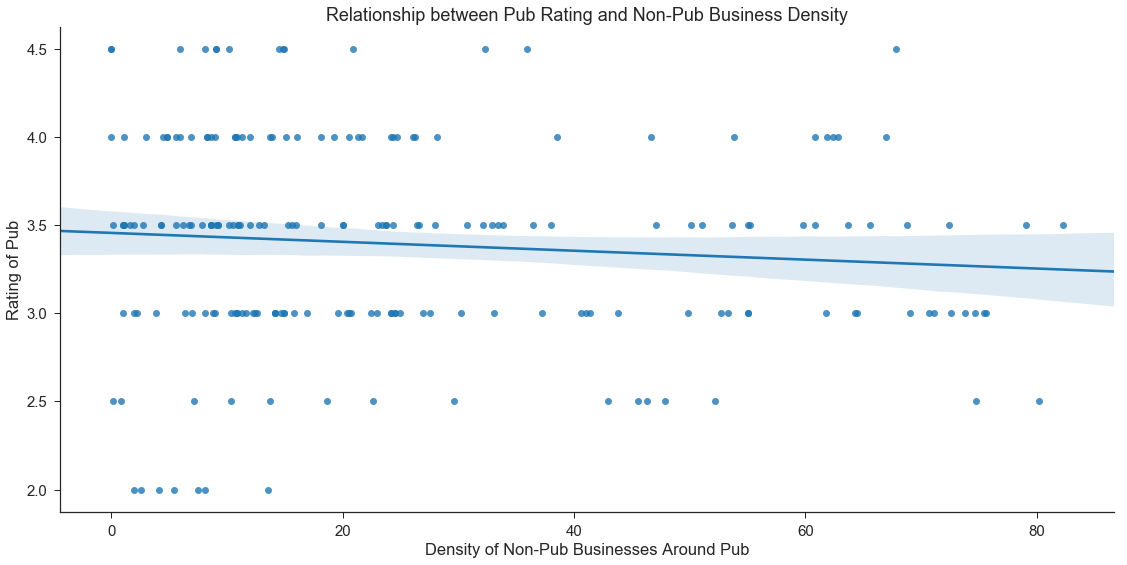

In [40]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="density", y="rating", size=8, data=final_businesses_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Pub Rating and Non-Pub Business Density")
plt.xlabel('Density of Non-Pub Businesses Around Pub')
plt.ylabel('Rating of Pub')

It seems from the above graph that there is no definite relationship between ratings of pubs and density of businesses. Infact. there seem to be more higher and lower rating pubs in low density areas as compared to high density areas in Toronto.